In [1]:
import pandas as pd
import numpy as np
import vegas
import sys
import os
sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")
import lhapdf


from scipy.interpolate import interp1d
from scipy import integrate

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

palette = plt.get_cmap('Set1')
%matplotlib inline
%config InlineBackend.figure_format='retina'

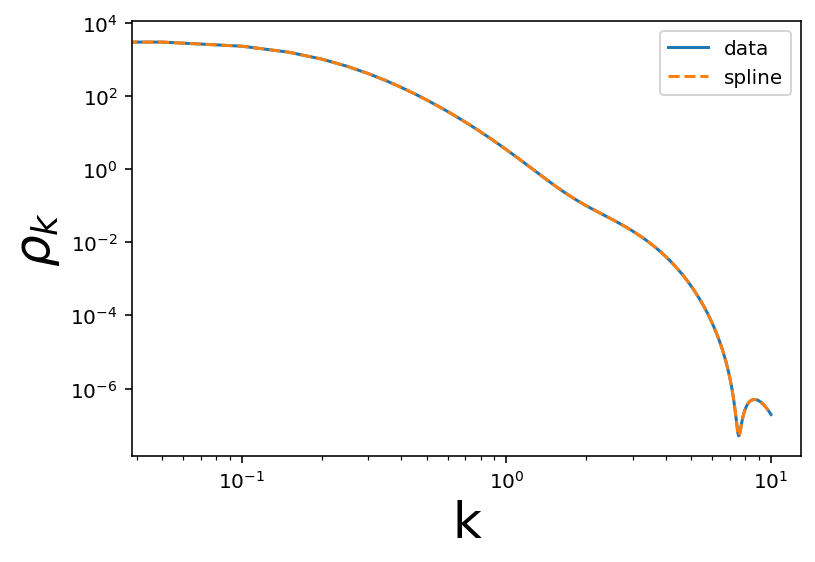

In [2]:
momentum = pd.read_csv('nk_deut.dat', sep='\s+', names=['k','rs','rd','rk'], dtype=np.float64,skiprows=2)
"""Plot the momentum distribution."""
plt.figure(figsize=(6,4));plt.rc('axes', labelsize=25, titlesize=30);plt.plot(momentum['k'],momentum['rk'],label='data');
ps = interp1d(momentum['k'],momentum['rk'], kind='cubic');xnew = np.linspace(0, 10, 200);plt.plot(xnew, ps(xnew),'--',label='spline')
plt.xscale('log');plt.yscale('log');plt.xlabel('k');plt.ylabel(r'$\rho_k$');plt.legend();plt.show()

In [3]:
def psg(pprime):
    hbarc = 197.32*1e-3 ; p = pprime/hbarc
    return ps(p)/hbarc**3 # answer in GeV.

In [12]:
class DIS:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name):
        self.pdfSet = lhapdf.mkPDFs(name)
        self.xfxQ2_vec = np.vectorize(self.__call__)

    def __call__(self, pdf, i, x, q2):
        return pdf.xfxQ2(i, x, q2)
    
    def F2p(self, x, q2, iset=None):
        charge2 = [4/9, 1/9]
        if iset is None:
            size = 1
            if isinstance(q2, np.ndarray):
                size = len(q2)
            result = np.zeros((len(self.pdfSet), size))
            for j, pdf in enumerate(self.pdfSet):
                for i in range(1, 6):
                    result[j] += charge2[i%2]*(self.xfxQ2_vec(pdf, i, x, q2) + self.xfxQ2_vec(pdf, -i, x, q2))
            
            return result
        else:
            result = 0
            for i in range(1, 6):
                result += charge2[i%2]*(self.xfxQ2_vec(self.pdfSet[iset], i, x, q2) + self.xfxQ2_vec(self.pdfSet[iset], -i, x, q2))
                
            return result

    def F2n(self, x, q2, iset=None):
        charge2 = [1/9, 4/9]
        if iset is None:
            size = 1
            if isinstance(q2, np.ndarray):
                size = len(q2)
            result = np.zeros((len(self.pdfSet), size))
            for j, pdf in enumerate(self.pdfSet):
                for i in range(1, 6):
                    result[j] += charge2[i%2]*(self.xfxQ2_vec(pdf, i, x, q2) + self.xfxQ2_vec(pdf, -i, x, q2))
            
            return result
        else:
            result = 0
            for i in range(1, 6):
                result += charge2[i%2]*(self.xfxQ2_vec(self.pdfSet[iset], i, x, q2) + self.xfxQ2_vec(self.pdfSet[iset], -i, x, q2))
            
        return result
    
    def F1p(self, x, q2, iset=None):
        return self.F2p(x, q2, iset)/(2*x)
    
    def F1n(self, x, q2, iset=None):
        return self.F2n(x, q2, iset)/(2*x)

In [5]:
m_p       = 0.938    # mass of proton in GeV.
m_n       = 0.939    # mass of neutron in GeV.
M_A = m_p # entire deuteron nucleus mass.

In [6]:
class deut_DIS_dbl:
    def __init__(self, xa, pdf):
        self.pdf = DIS(pdf)       
        self.xa  = xa
#        self.E   = E
    
    def qvec(self,q2):
        return np.sqrt(q2+self.omega(q2)**2)
    def omega(self,q2):
        return q2/(2*M_A*self.xa)
    def omega_t(self,p,m,q2):
        wt=self.omega(q2)-2*np.sqrt(p**2+m**2)+2*m-0.002
      #  if (wt<0):
      #      wt=self.omega(q2)
        return wt
    def q2t(self,q2,p,m):
        return self.qvec(q2)**2-self.omega_t(p,m,q2)**2
        
    def phase_space(self,p,m,flag):
        if(flag==True):
            ph_sp=2*np.pi*p**2*psg(p)/(2*np.pi)**3*m/np.sqrt(p**2+m**2)#
        else:
            ph_sp= 1
        return ph_sp
        
    def xn(self,p,m,cosT,q2):
        if(p==0):
            return self.xa
        else:
            ep=np.sqrt(p**2+m**2)
            pdotq=ep*self.omega(self.q2)-p*cosT*self.qvec(self.q2)
            return q2/2/pdotq
        
    def f2A(self, p,costh, q2, iset):
        self.q2=q2
        sinth = np.sqrt(1-costh**2)
        #dI = np.zeros_like(self.q2_bins)
        ep=np.sqrt(p**2+m_p**2)
        pdotq=ep*self.omega_t(p,m_p,self.q2)-p*costh*self.qvec(self.q2)

        x_p=self.xn(p,m_p,costh,self.q2)
        I=0
        
        if x_p < 0 or x_p > 1:
            return I
        else:
            q2t=self.q2t(q2,p,m_p)
            term1=self.omega(self.q2)*self.pdf.F1p(x_p,q2t,iset)/m_p*self.q2/self.qvec(self.q2)**2*(1-self.q2/self.q2t(self.q2,p,m_p))
            term2=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2p(x_p,q2t,iset)/m_p**2*(ep+(pdotq)/self.q2t(q2,p,m_p)*self.omega_t(p,m_p,self.q2))**2
            term3=self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2p(x_p,q2t,iset)/m_p**2
            f2p=term1+term2+term3
            print(term1, term2, term3)
            term1=self.omega(self.q2)*self.pdf.F1n(x_p,q2t,iset)/m_p*self.q2/self.qvec(self.q2)**2*(1-self.q2/self.q2t(self.q2,p,m_p))
            term2=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2n(x_p,q2t,iset)/m_p**2*(ep+(pdotq)/self.q2t(q2,p,m_p)*self.omega_t(p,m_p,self.q2))**2
            term3=self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2n(x_p,q2t,iset)/m_p**2
            f2n=term1+term2+term3       
            # self.pdf.F1p(x_p,self.q2)*self.q2/self.qvec(self.q2)**2*(self.q2/self.q2t(self.q2,p,m_p)-1)  
            
            
            I = self.phase_space(p,m_p,True)*(f2p+f2n)
          #  j = np.searchsorted(self.q2_bins, self.q2)

          #  dI[j] = I/np.diff(self.q2_bins)[j-1]
          #  if np.any(dI < 0):
          #      print(dI)
        
        return I
    
    def f1A(self, p,costh, q2):
        self.q2=q2
        
        sinth = np.sqrt(1-costh**2)

        x_p=self.xn(p,m_p,costh,self.q2)
        I=0
        if x_p < 0 or x_p > 1:
            return I
        else:

            f1p=M_A*(self.pdf.F1p(x_p,self.q2)/m_p 
                +self.pdf.F2p(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
            f1n=M_A*(self.pdf.F1n(x_p,self.q2)/m_p 
                +self.pdf.F2n(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
        
            I = self.phase_space(p,m_p,True)*(f1p+f1n)
            #I=f1p
            #j = np.searchsorted(self.q2_bins, self.q2)


            #dI[j] = I/np.diff(self.q2_bins)[j-1]
            #if np.any(dI < 0):
            #    print(dI)
        
        return I

In [2]:
experimental = pd.read_csv('HEPData-ins280954-v1-Table_1.csv', header=12, names=['Q2', 'F2', 'stat+', 'stat-', 'sys+', 'sys-'], dtype=np.float64)
experimental['error'] = np.sqrt(experimental['stat+']**2 + experimental['sys+']**2)
experimental['Q2'].to_numpy()

array([0.583, 0.662, 0.811, 0.893, 1.013, 1.116, 1.255, 1.44 , 1.531,
       1.662, 1.801, 1.979, 2.153, 2.419])

In [19]:
def get_error(values):
    err_up = 0
    err_dw = 0
    for i in range(1,(len(values)-1), 2):
        err_up += np.where(values[i]-values[0] > values[i+1]-values[0], (values[i]-values[0])**2, (values[i+1]-values[0])**2)
        err_dw += np.where(values[0]-values[i] > values[0]-values[i+1], (values[0]-values[i])**2, (values[0]-values[i+1])**2)
        
    return np.sqrt(err_up), np.sqrt(err_dw)

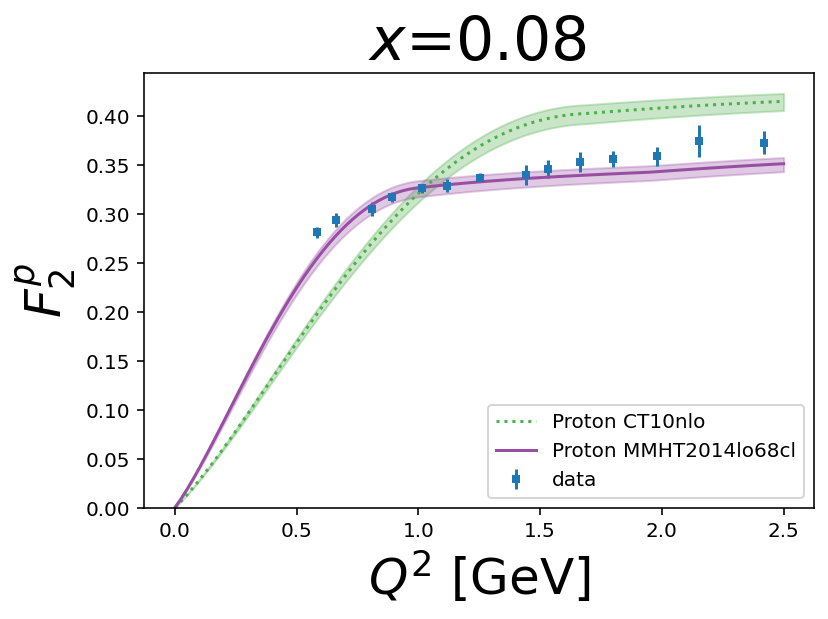

In [9]:
dis = DIS("MMHT2014lo68cl")
dis_ct14lo = DIS("CT14nlo")
dis_ct10 = DIS("CT10nlo")
dis_cteq66= DIS("cteq66")

x=0.08
q2=np.linspace(0,2.5,100)

F2p_ct10 = dis_ct10.F2p(x, q2)
F2p_MMHT = dis.F2p(x, q2)

err_up_ct10, err_dw_ct10 = get_error(F2p_ct10)
err_up_MMHT, err_dw_MMHT = get_error(F2p_MMHT)

fig, ax = plt.subplots()
plt.plot(q2, dis_ct10.F2p(x, q2)[0, :],color=palette(2),linestyle=':',label='Proton CT10nlo') 
ax.fill_between(q2, F2p_ct10[0, :] - err_dw_ct10/1.645, F2p_ct10[0, :] + err_up_ct10/1.645,color=palette(2),linestyle='-',alpha=0.3)
plt.plot(q2, F2p_MMHT[0, :],color=palette(3),linestyle='-',label='Proton MMHT2014lo68cl') 
ax.fill_between(q2, F2p_MMHT[0, :] - err_dw_MMHT, F2p_MMHT[0, :] + err_up_MMHT,color=palette(3),linestyle='-',alpha=0.3)

plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')

plt.title(r'$x$=0.08 ')
plt.xlabel(r'$Q^2$ [GeV]')
plt.ylabel(r'$F_{2}^{p}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,)
plt.legend(loc=0, ncol=1)
plt.savefig('f2p_compare.pdf', bbox_inches='tight')

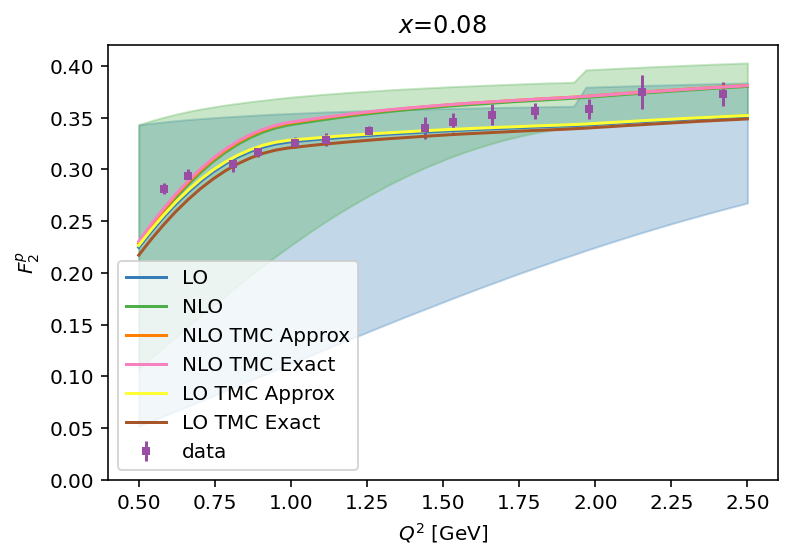

In [8]:
theory = pd.read_csv('F2p_x_008.dat', names=['Q2', 'F2pLO', 'F2pNLO'])
theory2 = pd.read_csv('F2p_x_008_mu2.dat', names=['Q2', 'F2pLO', 'F2pNLO'])
theory05 = pd.read_csv('F2p_x_008_mu05.dat', names=['Q2', 'F2pLO', 'F2pNLO'])
theoryLO = pd.read_csv('F2p_x_008_LO.dat', names=['Q2', 'F2pLO', 'F2pNLO'])
theoryLO2 = pd.read_csv('F2p_x_008_LO_2.dat', names=['Q2', 'F2pLO', 'F2pNLO'])
theoryLO05 = pd.read_csv('F2p_x_008_LO_05.dat', names=['Q2', 'F2pLO', 'F2pNLO'])
theoryTMC = pd.read_csv('F2p_x_008_TMC_NLO_approx.dat', names=['Q2', 'F2pLO', 'F2pNLO',
                                                               'F2pLO_TMC_a', 'F2pNLO_TMC_a',
                                                               'F2pLO_TMC', 'F2pNLO_TMC'])
theoryTMC0 = pd.read_csv('F2p_x_008_TMC_LO_approx.dat', names=['Q2', 'F2pLO', 'F2pNLO',
                                                               'F2pLO_TMC_a', 'F2pNLO_TMC_a',
                                                               'F2pLO_TMC', 'F2pNLO_TMC'])

fig, ax = plt.subplots()
plt.plot(theory['Q2'], theoryLO['F2pLO'], label='LO', color=palette(1))
plt.plot(theory['Q2'], theory['F2pNLO'], label='NLO', color=palette(2))
plt.plot(theory['Q2'], theoryTMC['F2pNLO_TMC_a'], label='NLO TMC Approx', color=palette(4))
plt.plot(theory['Q2'], theoryTMC['F2pNLO_TMC'], label='NLO TMC Exact', color=palette(7))
plt.plot(theory['Q2'], theoryTMC0['F2pLO_TMC_a'], label='LO TMC Approx', color=palette(5))
plt.plot(theory['Q2'], theoryTMC0['F2pLO_TMC'], label='LO TMC Exact', color=palette(6))
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3', color=palette(3))
ax.fill_between(theory['Q2'], theoryLO05['F2pLO'], theoryLO2['F2pLO'],color=palette(1),linestyle='-',alpha=0.3)
ax.fill_between(theory['Q2'], theory05['F2pNLO'], theory2['F2pNLO'],color=palette(2),linestyle='-',alpha=0.3)

plt.title(r'$x$=0.08 ')
plt.xlabel(r'$Q^2$ [GeV]')
plt.ylabel(r'$F_{2}^{p}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,)
plt.legend(loc=0, ncol=1)
plt.savefig('f2p_compare.pdf', bbox_inches='tight')

In [14]:
x=0.08
nq=10

x=0.175
deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
integral=np.zeros((len(deut_Q2.pdf.pdfSet),nq,2))
q2=np.linspace(0.1,2.5,nq)

deut_Q2.f2A(0.04196066066168969, -0.9838831710329653, 10, 0)
# for j in range(len(deut_Q2.pdf.pdfSet)):
#     print(f'Calculating for pdf # {j} / {len(deut_Q2.pdf.pdfSet)}')
#     for i in range(nq):
#         integral[j,i]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],j),epsabs=1.49e-03)
#         print(f'  I({q2[i]}) = {integral[j, i, 0]} +/- {integral[j, i, 1]}')

0.008134435023105775 0.3552552629654634 1.1633177658378975e-07


3.4867931432010124

In [11]:
experimental = pd.read_csv('HEPData-ins280954-v1-Table_13.csv', header=10, names=['Q2', 'F2', 'stat+', 'stat-', 'sys+', 'sys-'], dtype=np.float64)
experimental['error'] = np.sqrt(experimental['stat+']**2 + experimental['sys+']**2)
experimental['Q2'].to_numpy()

array([0.582, 0.662, 0.811, 0.893, 1.012, 1.117, 1.24 , 1.44 , 1.532,
       1.661, 1.808, 1.993, 2.146, 2.419])

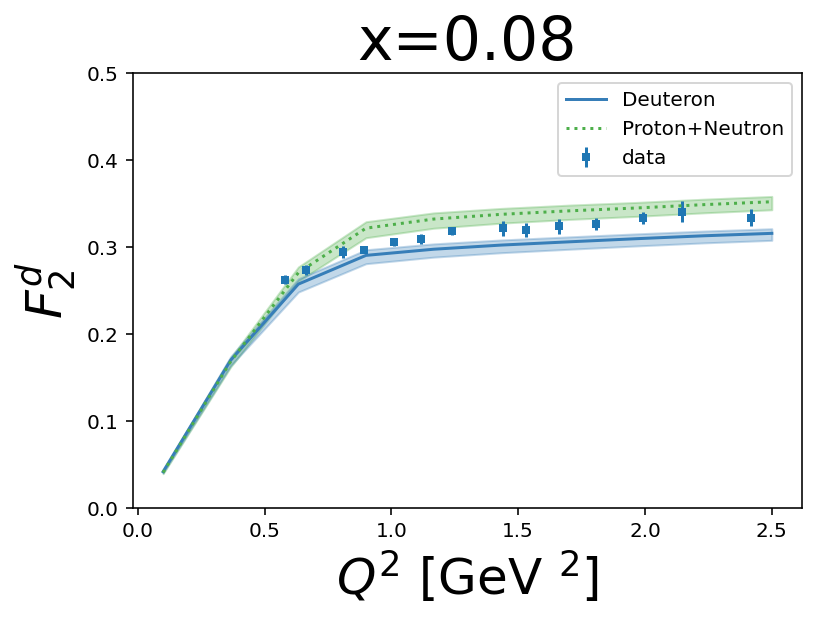

In [37]:
x=0.08
# Experiment
#mask = experimental['Q2']
#exp = experimental[ma
dis_ct14lo=DIS("MMHT2014lo68cl")
dis_pn = (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2
dis_d = integral[..., 0]/2

err_up_pn, err_dw_pn = get_error(dis_pn)
err_up_d, err_dw_d = get_error(dis_d)

fig, ax = plt.subplots()
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,dis_d[0], color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, dis_pn[0],color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')
ax.fill_between(q2, dis_pn[0, :] - err_dw_pn, dis_pn[0, :] + err_up_pn,color=palette(2),linestyle='-',alpha=0.3)
ax.fill_between(q2, dis_d[0, :] - err_dw_d, dis_d[0, :] + err_up_d,color=palette(1),linestyle='-',alpha=0.3)


plt.title(r'x=0.08')
plt.xlabel(r'$Q^2$ [GeV $^2$]')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.5)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_0p08_0p1top2p5.pdf', bbox_inches='tight')





In [12]:
x=0.08
nq=10
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='CT14lo')
q2=np.linspace(0.1,2.5,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-04)
    print(integral[i,:])

[5.32208974e-02 3.46007602e-05]
[2.33090333e-01 1.48811658e-04]
[4.05017554e-01 6.83056070e-05]
[5.35970601e-01 8.84914301e-05]
[6.17146201e-01 1.03699470e-04]
[6.53076471e-01 1.14316466e-04]
[6.60785951e-01 1.15697582e-04]
[6.64954991e-01 1.16936331e-04]
[6.68294795e-01 1.16960883e-04]
[6.71101725e-01 1.17475740e-04]


In [39]:
experimental = pd.read_csv('HEPData-ins262063-v1-Table_1.csv', header=29, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental['error'] = experimental['error+']
experimental['Q2'].to_numpy()

array([1. , 1.5, 2.5, 5. ])

In [40]:
x=0.2
nq=15


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
integral=np.zeros((len(deut_Q2.pdf.pdfSet),nq,2))
q2=np.linspace(0.05,5.0,nq)
for j in range(len(deut_Q2.pdf.pdfSet)):
    print(f'Calculating for pdf # {j} / {len(deut_Q2.pdf.pdfSet)}')
    for i in range(nq):
        integral[j,i]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],j),epsabs=1.49e-03)
        print(f'  I({q2[i]}) = {integral[j, i, 0]} +/- {integral[j, i, 1]}')

Calculating for pdf # 0 / 51
  I(0.05) = 0.0356817107696769 +/- 0.0011430309654178886
  I(0.4035714285714286) = 0.3686601875945799 +/- 0.00024524772978352753
  I(0.7571428571428572) = 0.5701869830330422 +/- 0.0003888568645799787
  I(1.1107142857142858) = 0.5919395002803578 +/- 0.0004044332554463924
  I(1.4642857142857144) = 0.5869803320049707 +/- 0.0004037508786581545
  I(1.817857142857143) = 0.5826867838749675 +/- 0.0004106060112811973
  I(2.1714285714285713) = 0.5799506728633431 +/- 0.0003973409458159598
  I(2.525) = 0.5776182606389055 +/- 0.00039589765923532527
  I(2.8785714285714286) = 0.5753465995629469 +/- 0.0003943691432550418
  I(3.232142857142857) = 0.5732313168427995 +/- 0.0003931489014487293
  I(3.585714285714286) = 0.571255268385878 +/- 0.000391814609659244
  I(3.9392857142857145) = 0.5694089210411486 +/- 0.0003907154741072446
  I(4.292857142857143) = 0.5676778613365089 +/- 0.0003895808060253407
  I(4.646428571428571) = 0.5660506357541191 +/- 0.00038850238129336037
  I(5.0)

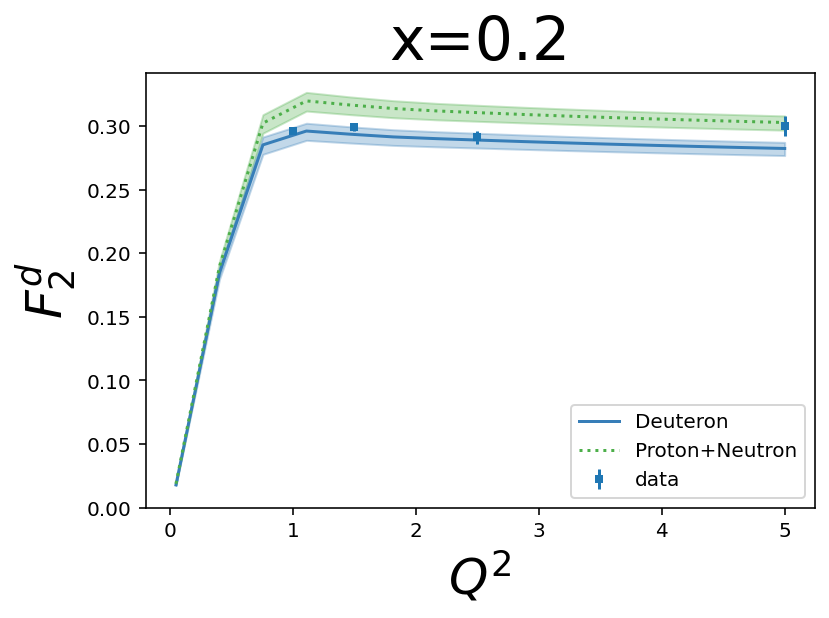

In [19]:
x=0.2
# Experiment
#mask = experimental['Q2']
#exp = experimental[ma
dis_ct14lo=DIS("MMHT2014lo68cl")
dis_pn = (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2
dis_d = integral[..., 0]/2

err_up_pn, err_dw_pn = get_error(dis_pn)
err_up_d, err_dw_d = get_error(dis_d)

fig, ax = plt.subplots()
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,dis_d[0], color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, dis_pn[0],color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')
ax.fill_between(q2, dis_pn[0, :] - err_dw_pn, dis_pn[0, :] + err_up_pn,color=palette(2),linestyle='-',alpha=0.3)
ax.fill_between(q2, dis_d[0, :] - err_dw_d, dis_d[0, :] + err_up_d,color=palette(1),linestyle='-',alpha=0.3)


plt.title(r'x=0.2')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_0p2_0p5tp5.pdf', bbox_inches='tight')

In [9]:
experimental_tb5 = pd.read_csv('HEPData-ins188737-v1-Table_5.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental_tb5['error'] = experimental_tb5['error+']
experimental_tb5['Q2'].to_numpy()

array([11.5, 15. , 20. , 27. , 36. , 48. , 65. ])

In [14]:
x=0.175
nq=20


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
integral=np.zeros((len(deut_Q2.pdf.pdfSet),nq,2))
q2=np.linspace(11,65.0,nq)
for j in range(len(deut_Q2.pdf.pdfSet)):
    print(f'Calculating for pdf # {j} / {len(deut_Q2.pdf.pdfSet)}')
    for i in range(nq):
        integral[j,i]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],j),epsabs=1.49e-03)
        print(f'  I({q2[i]}) = {integral[j, i, 0]} +/- {integral[j, i, 1]}')

NameError: name 'deut_DIS_dbl' is not defined

In [21]:
x=0.175
nq=20
q2=np.linspace(11,65.0,nq)
theory = pd.read_csv('F2d_x_0175.dat')
theory_nlo = pd.read_csv('F2d_x_0175_NLO.dat')
theory_nlo_tmc = pd.read_csv('F2d_x_0175_NLO_TMC.dat')
theory

,q2,val,stat_err,pdf_err+,pdf_err-
0,10.00,0.2885,0.001837,0.005405,0.004580
1,16.11,0.2846,0.001811,0.005107,0.004350
2,22.22,0.2821,0.001796,0.004914,0.004219
3,28.33,0.2804,0.001787,0.004777,0.004131
4,34.44,0.2786,0.001777,0.004670,0.004060
5,40.56,0.2772,0.001764,0.004586,0.003998
6,46.67,0.2759,0.001758,0.004524,0.003945
7,52.78,0.2750,0.001752,0.004482,0.003910
8,58.89,0.2745,0.001750,0.004437,0.003874
9,65.00,0.2732,0.001741,0.004373,0.003829


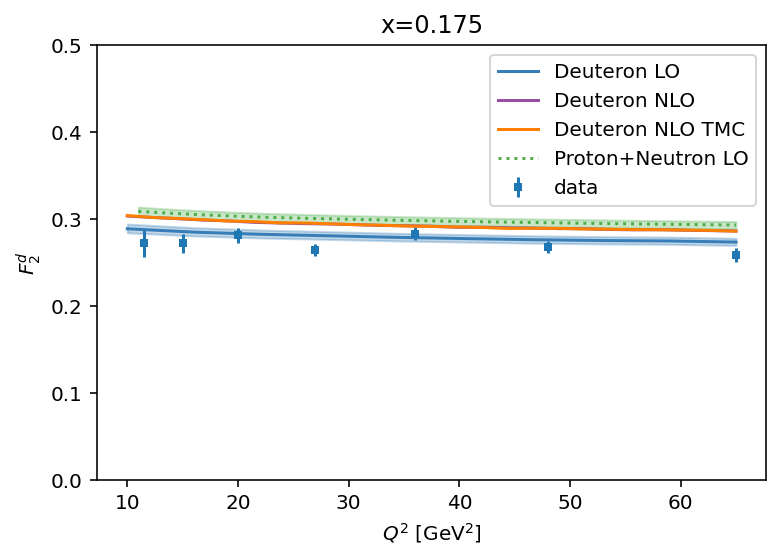

In [22]:
# Experiment
#mask = experimental['Q2']
#exp = experimental[ma
dis_ct14lo=DIS("MMHT2014lo68cl")
dis_pn_tb5 = (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2
# dis_d_tb5 = integral[..., 0]/2

err_up_pn_tb5, err_dw_pn_tb5 = get_error(dis_pn_tb5)
# err_up_d_tb5, err_dw_d_tb5 = get_error(dis_d_tb5)

fig, ax = plt.subplots()
plt.errorbar(experimental_tb5['Q2'], experimental_tb5['F2'], yerr=experimental_tb5['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(theory['q2'],theory['val'], color=palette(1),linestyle='-',label='Deuteron LO')
plt.plot(theory_nlo['q2'],theory_nlo['val'], color=palette(3),linestyle='-',label='Deuteron NLO')
plt.plot(theory_nlo_tmc['q2'],theory_nlo_tmc['val'], color=palette(4),linestyle='-',label='Deuteron NLO TMC')
plt.plot(q2, dis_pn_tb5[0],color=palette(2),linestyle=':',label='Proton+Neutron LO')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')
ax.fill_between(q2, dis_pn_tb5[0, :] - err_dw_pn_tb5, dis_pn_tb5[0, :] + err_up_pn_tb5,color=palette(2),linestyle='-',alpha=0.3)
ax.fill_between(theory['q2'], theory['val'] - theory['pdf_err-'], theory['val'] + theory['pdf_err+'],color=palette(1),linestyle='-',alpha=0.3)


plt.title(r'x=0.175')
plt.xlabel(r'$Q^2$ [GeV$^2$]')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.5)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_0175.pdf', bbox_inches='tight')

In [14]:
experimental_tb6 = pd.read_csv('HEPData-ins188737-v1-Table_6.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental_tb6['error'] = experimental['error+']
experimental_tb6['Q2'].to_numpy()

array([11.5, 15. , 20. , 27. , 36. , 48. , 65. , 90. ])

In [15]:
x=0.25
nq=20


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
integral=np.zeros((len(deut_Q2.pdf.pdfSet),nq,2))
q2=np.linspace(10,90.0,nq)
for j in range(len(deut_Q2.pdf.pdfSet)):
    print(f'Calculating for pdf # {j} / {len(deut_Q2.pdf.pdfSet)}')
    for i in range(nq):
        integral[j,i]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],j),epsabs=1.49e-03)
        print(f'  I({q2[i]}) = {integral[j, i, 0]} +/- {integral[j, i, 1]}')


Calculating for pdf # 0 / 51
  I(10.0) = 0.4938137885197112 +/- 0.0003396834354562842
  I(14.210526315789473) = 0.48259056839911635 +/- 0.0003320355728845016
  I(18.421052631578945) = 0.47452923148544274 +/- 0.00032739126049582436
  I(22.63157894736842) = 0.4682617579047444 +/- 0.0003224514125221515
  I(26.842105263157894) = 0.46351800060033055 +/- 0.00031927725386632876
  I(31.052631578947366) = 0.45948454067302397 +/- 0.00031657739774198015
  I(35.26315789473684) = 0.45599248939916615 +/- 0.00031422797906707246
  I(39.473684210526315) = 0.452934487158771 +/- 0.0003121897935129993
  I(43.68421052631579) = 0.4502170069418354 +/- 0.0003103685027334678
  I(47.89473684210526) = 0.4477702257479814 +/- 0.0003087351311340872
  I(52.10526315789473) = 0.44554711845730854 +/- 0.00030724850927339904
  I(56.315789473684205) = 0.44351181331466616 +/- 0.0003058857223684659
  I(60.526315789473685) = 0.44163634010866926 +/- 0.00030462507403080166
  I(64.73684210526315) = 0.4398985120466337 +/- 0.0003

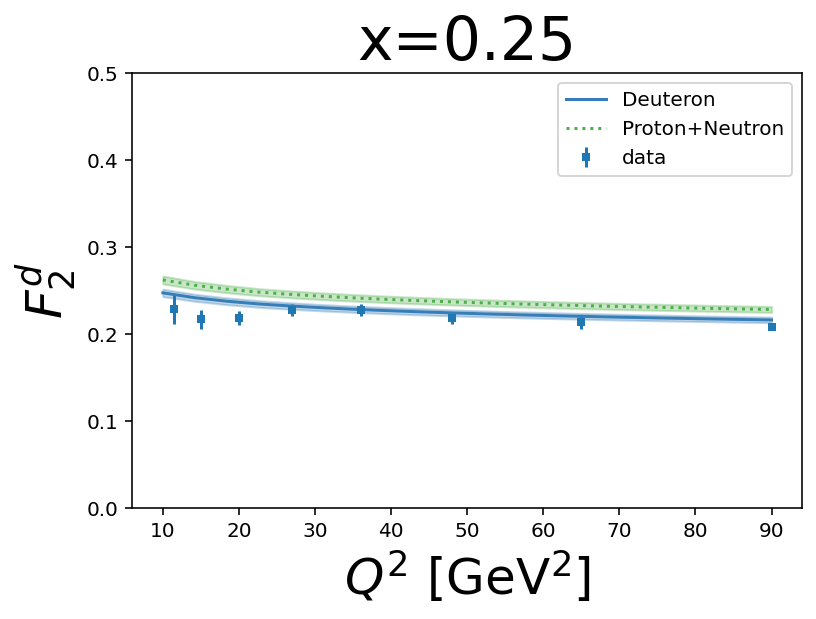

In [16]:
dis_ct14lo=DIS("MMHT2014lo68cl")
dis_pn_tb6 = (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2
dis_d_tb6 = integral[..., 0]/2

err_up_pn_tb6, err_dw_pn_tb6 = get_error(dis_pn_tb6)
err_up_d_tb6, err_dw_d_tb6 = get_error(dis_d_tb6)

fig, ax = plt.subplots()
plt.errorbar(experimental_tb6['Q2'], experimental_tb6['F2'], yerr=experimental_tb6['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,dis_d_tb6[0], color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, dis_pn_tb6[0],color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')
ax.fill_between(q2, dis_pn_tb6[0, :] - err_dw_pn_tb6, dis_pn_tb6[0, :] + err_up_pn_tb6,color=palette(2),linestyle='-',alpha=0.3)
ax.fill_between(q2, dis_d_tb6[0, :] - err_dw_d_tb6, dis_d_tb6[0, :] + err_up_d_tb6,color=palette(1),linestyle='-',alpha=0.3)


plt.title(r'x=0.25')
plt.xlabel(r'$Q^2$ [GeV$^2$]')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.5)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_x0p125_q210t90.pdf', bbox_inches='tight')

In [17]:
experimental_tb4 = pd.read_csv('HEPData-ins188737-v1-Table_4.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental_tb4['error'] = experimental_tb4['error+']
experimental_tb4['Q2'].to_numpy()

array([ 9. , 11.5, 15. , 20. , 27. , 36. , 48. , 65. ])

In [18]:
x=0.125
nq=20


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
integral=np.zeros((len(deut_Q2.pdf.pdfSet),nq,2))
q2=np.linspace(9,65.0,nq)
for j in range(len(deut_Q2.pdf.pdfSet)):
    print(f'Calculating for pdf # {j} / {len(deut_Q2.pdf.pdfSet)}')
    for i in range(nq):
        integral[j,i]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],j),epsabs=1.49e-03)
        print(f'  I({q2[i]}) = {integral[j, i, 0]} +/- {integral[j, i, 1]}')


Calculating for pdf # 0 / 51
  I(9.0) = 0.6240000094014194 +/- 0.00042656096989726264
  I(11.947368421052632) = 0.6240150805446846 +/- 0.00042551730469186054
  I(14.894736842105264) = 0.6235893031324561 +/- 0.00042590743700350424
  I(17.842105263157894) = 0.6231605723302271 +/- 0.00043170335537021445
  I(20.789473684210527) = 0.622877906881523 +/- 0.00047434533359493915
  I(23.736842105263158) = 0.6230134548981088 +/- 0.0004243383150993041
  I(26.684210526315788) = 0.6230892321737868 +/- 0.00042664990620702205
  I(29.63157894736842) = 0.6230636883066034 +/- 0.00042671320037299294
  I(32.578947368421055) = 0.6229845295991329 +/- 0.000426739355047695
  I(35.526315789473685) = 0.6228694323093832 +/- 0.00042664093998320135
  I(38.473684210526315) = 0.6227297107834862 +/- 0.00042662955835660703
  I(41.421052631578945) = 0.622571160102257 +/- 0.00042660064185470227
  I(44.368421052631575) = 0.6223983185401223 +/- 0.00042652276265623887
  I(47.315789473684205) = 0.6222160260053238 +/- 0.00042

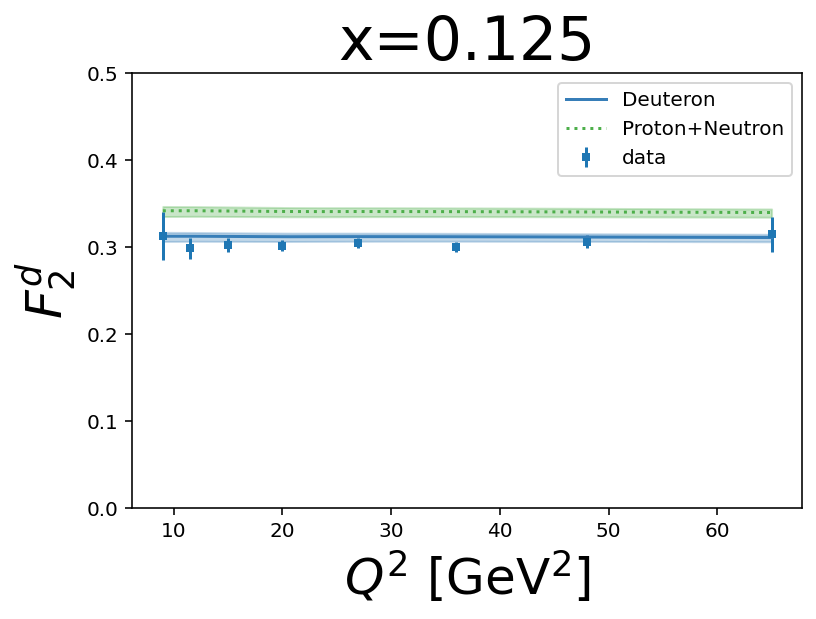

In [21]:
dis_ct14lo=DIS("MMHT2014lo68cl")
dis_pn_tb4 = (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2
dis_d_tb4 = integral[..., 0]/2

err_up_pn_tb4, err_dw_pn_tb4 = get_error(dis_pn_tb4)
err_up_d_tb4, err_dw_d_tb4 = get_error(dis_d_tb4)

fig, ax = plt.subplots()
plt.errorbar(experimental_tb4['Q2'], experimental_tb4['F2'], yerr=experimental_tb4['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,dis_d_tb4[0], color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, dis_pn_tb4[0],color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')
ax.fill_between(q2, dis_pn_tb4[0, :] - err_dw_pn_tb4, dis_pn_tb4[0, :] + err_up_pn_tb4,color=palette(2),linestyle='-',alpha=0.3)
ax.fill_between(q2, dis_d_tb4[0, :] - err_dw_d_tb4, dis_d_tb4[0, :] + err_up_d_tb4,color=palette(1),linestyle='-',alpha=0.3)


plt.title(r'x=0.125')
plt.xlabel(r'$Q^2$ [GeV$^2$]')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.5)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_x0p125_q210t60.pdf', bbox_inches='tight')

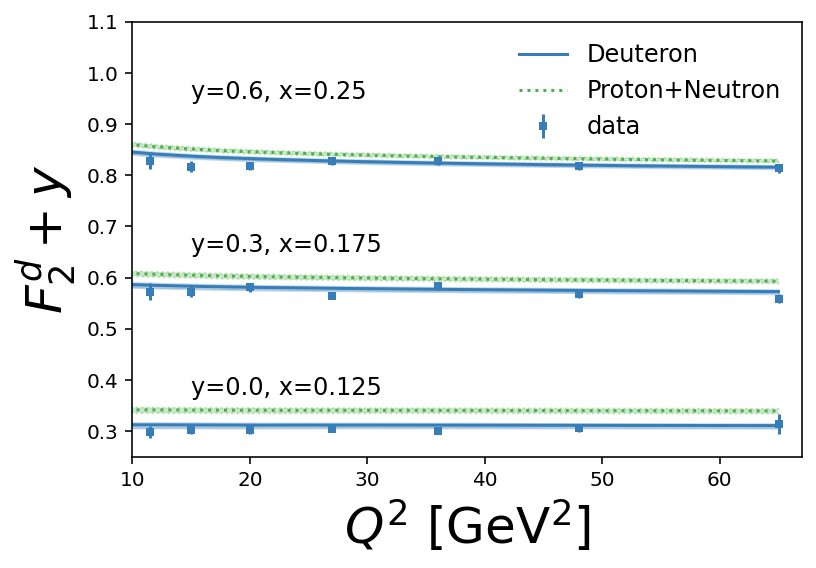

In [62]:
fig, ax = plt.subplots()
def plot(ax, q2, x, exp, th_d, th_d_errup, th_d_errdw, th_pn, th_pn_errup, th_pn_errdw):
    def plot_theory(ax, q2, x, th, errup, errdw, color, label, ls):
        plt.plot(q2, th[0]+x, color=color, ls=ls, label=label)
        ax.fill_between(q2, (th[0]+x-errdw), (th[0]+x + errup), color=color, ls=ls, alpha=0.3)
        
    plt.errorbar(exp['Q2'], exp['F2']+x, yerr=exp['error'], label='data', ls='', marker='s', markersize='3', color=palette(1))
    plot_theory(ax, q2, x, th_d, th_d_errup, th_d_errdw, palette(1), 'Deuteron', '-')
    plot_theory(ax, q2, x, th_pn, th_pn_errup, th_pn_errdw, palette(2), 'Proton+Neutron', ':')
    
    
plot(ax, q2, 0, experimental_tb4, dis_d_tb4, err_up_d_tb4, err_dw_d_tb4, dis_pn_tb4, err_up_pn_tb4, err_dw_pn_tb4)
plot(ax, q2, 0.3, experimental_tb5, dis_d_tb5, err_up_d_tb5, err_dw_d_tb5, dis_pn_tb5, err_up_pn_tb5, err_dw_pn_tb5)
plot(ax, q2, 0.6, experimental_tb6, dis_d_tb6, err_up_d_tb6, err_dw_d_tb6, dis_pn_tb6, err_up_pn_tb6, err_dw_pn_tb6)
plt.xlim([10, 67])
plt.ylim([0.25, 1.1])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=False, fontsize=12)
plt.xlabel(r'$Q^{2}$ [GeV$^{2}$]')
plt.ylabel(r'$F_{2}^d+y$')
plt.text(15, 0.95,r'y=0.6, x=0.25',fontsize=12)
plt.text(15, 0.65,r'y=0.3, x=0.175',fontsize=12)
plt.text(15, 0.37,r'y=0.0, x=0.125',fontsize=12)
plt.savefig('f2d_compare.pdf', bbox_inches='tight')